# PROYECTO FINAL: ANÁLISIS DE SENTIMIENTOS CON LSTM
## Redes Neuronales - Facultad de Ciencias, UNAM

----

**Dataset:** IMDB Movie Reviews (50,000 reseñas)
**Arquitectura:** LSTM bidireccional con Dropout
**Framework:** PyTorch

---

Alumnos:
 - Orta Castillo Maria de los Angeles -
 - Solano Juarez Sebastian

Fecha de entrega : 7 de diciembre del 2025

In [1]:
# Bibliotecas a usar
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
import os

# Para cargar el dataset de IMDB
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

1. CONFIGURACIÓN E HIPERPARÁMETROS

In [2]:
# Hiperparámetros del modelo
VOCAB_SIZE = 10000        # Tamaño del vocabulario
EMBEDDING_DIM = 128       # Dimensión de los embeddings
HIDDEN_DIM = 64          # Unidades en primera LSTM
DROPOUT_RATE = 0.5       # Tasa de regularización
MAX_LENGTH = 256         # Longitud máxima de secuencias

# Hiperparámetros de entrenamiento
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cpu


2. CARGA Y PREPROCESAMIENTO DEL DATASET

In [3]:
def load_imdb_data():
    """
    Se carga el dataset IMDB y realiza preprocesamiento.

    Returns:
        X_train, X_val, X_test: Secuencias tokenizadas y padded
        y_train, y_val, y_test: Labels (0=negativo, 1=positivo)
    """
    print("\n=== CARGANDO DATASET IMDB ===")

    # Cargar datos (ya vienen tokenizados)
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

    print(f"Tamaño original - Train: {len(X_train)}, Test: {len(X_test)}")
    print(f"Ejemplo de secuencia (primeras 10 palabras): {X_train[0][:10]}")
    print(f"Label ejemplo: {y_train[0]} (1=positivo, 0=negativo)")

    # Padding para uniformar longitudes
    X_train = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post', truncating='post')
    X_test = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post', truncating='post')

    # Crear conjunto de validación (20% del train)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"\nDivisión final:")
    print(f"  - Train: {len(X_train)} muestras")
    print(f"  - Validation: {len(X_val)} muestras")
    print(f"  - Test: {len(X_test)} muestras")
    print(f"  - Forma de cada secuencia: {X_train.shape[1]}")

    return X_train, X_val, X_test, y_train, y_val, y_test


3. DATASET PERSONALIZADO PARA PYTORCH

In [4]:
class IMDBDataset(Dataset):
    """Dataset personalizado para PyTorch"""

    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

4. ARQUITECTURA DEL MODELO LSTM

In [5]:
class SentimentLSTM(nn.Module):
    """
    Modelo LSTM para clasificación de sentimientos.

    Arquitectura:
        1. Embedding Layer (VOCAB_SIZE -> EMBEDDING_DIM)
        2. LSTM Layer 1 (64 unidades) - CAPA COMPLEJA REQUERIDA
        3. Dropout (0.5) - REGULARIZACIÓN REQUERIDA
        4. LSTM Layer 2 (32 unidades)
        5. Dropout (0.3)
        6. Fully Connected (1 unidad con sigmoid)

    Esta arquitectura cumple con:
        - Capa compleja: 2 capas LSTM (recurrentes)
        - Regularización: Dropout al 50%
        - Clasificación binaria: Sigmoid en salida
    """

    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_rate):
        super(SentimentLSTM, self).__init__()

        # Capa de embedding: convierte índices de palabras en vectores densos
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Primera capa LSTM
        # return_sequences=True para pasar output a siguiente LSTM
        self.lstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,  # Input shape: (batch, seq, feature)
            dropout=0
        )

        # Dropout para regularización (previene overfitting)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Segunda capa LSTM (reduce dimensionalidad)
        self.lstm2 = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim // 2,
            num_layers=1,
            batch_first=True,
            dropout=0
        )

        # Segundo dropout
        self.dropout2 = nn.Dropout(dropout_rate)

        # Capa fully connected para clasificación binaria
        self.fc = nn.Linear(hidden_dim // 2, 1)

        # Activación sigmoid para salida entre 0 y 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass del modelo.

        Args:
            x: Tensor de shape (batch_size, seq_len) con índices de palabras

        Returns:
            Tensor de shape (batch_size, 1) con probabilidades [0-1]
        """
        # 1. Embedding: (batch, seq) -> (batch, seq, embedding_dim)
        embedded = self.embedding(x)

        # 2. Primera LSTM: captura dependencias secuenciales
        # lstm_out shape: (batch, seq, hidden_dim)
        # hidden shape: (1, batch, hidden_dim)
        lstm_out1, _ = self.lstm1(embedded)
        lstm_out1 = self.dropout1(lstm_out1)

        # 3. Segunda LSTM: abstracción de alto nivel
        lstm_out2, (hidden, cell) = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)

        # 4. Tomar el último estado oculto de la secuencia
        # hidden[-1] shape: (batch, hidden_dim // 2)
        last_hidden = hidden[-1]

        # 5. Fully connected + sigmoid
        out = self.fc(last_hidden)
        out = self.sigmoid(out)

        return out.squeeze()  # Remove extra dimension


5. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Entrena el modelo por una época"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for sequences, labels in progress_bar:
        sequences, labels = sequences.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Métricas
        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """Evalúa el modelo en un dataset"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for sequences, labels in tqdm(dataloader, desc="Evaluating"):
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            predictions = (outputs > 0.5).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    # Convertir a numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    # Calcular métricas usando sklearn
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    auc = roc_auc_score(all_labels, all_probabilities)

    return avg_loss, accuracy, precision, recall, f1, auc, all_predictions, all_labels


6. FUNCIÓN PARA GUARDAR PESOS Y CONFIGURACIÓN

In [7]:
def save_model_checkpoint(model, optimizer, epoch, history, config, filepath='model_checkpoint.pth'):
    """
    Guarda un checkpoint completo del modelo para poder reanudar entrenamiento.

    Args:
        model: Modelo de PyTorch
        optimizer: Optimizador
        epoch: Época actual
        history: Historial de entrenamiento
        config: Diccionario con configuración del modelo
        filepath: Ruta donde guardar el checkpoint
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'config': config
    }
    torch.save(checkpoint, filepath)
    print(f"✓ Checkpoint guardado en: {filepath}")


def save_model_for_inference(model, config, filepath='sentiment_model_weights.pth'):
    """
    Guarda únicamente los pesos del modelo y su configuración para inferencia.
    Este es el archivo que se debe compartir para evaluación.

    Args:
        model: Modelo entrenado
        config: Diccionario con hiperparámetros del modelo
        filepath: Ruta donde guardar los pesos
    """
    save_dict = {
        'model_state_dict': model.state_dict(),
        'config': config
    }
    torch.save(save_dict, filepath)
    print(f"✓ Pesos del modelo guardados en: {filepath}")

    # Mostrar tamaño del archivo
    file_size = os.path.getsize(filepath) / (1024 * 1024)  # MB
    print(f"  Tamaño del archivo: {file_size:.2f} MB")


def save_word_index(filepath='word_index.pkl'):
    """
    Guarda el diccionario palabra->índice necesario para inferencia.

    Args:
        filepath: Ruta donde guardar el diccionario
    """
    word_index = imdb.get_word_index()
    # Ajustar índices (IMDB agrega offset de 3)
    word_index = {k: (v + 3) for k, v in word_index.items()}
    word_index["<PAD>"] = 0
    word_index["<START>"] = 1
    word_index["<UNK>"] = 2
    word_index["<UNUSED>"] = 3

    with open(filepath, 'wb') as f:
        pickle.dump(word_index, f)

    print(f"✓ Diccionario de palabras guardado en: {filepath}")


7. ENTRENAMIENTO PRINCIPAL

In [8]:
def main():
    """Función principal de entrenamiento"""

    # Cargar datos
    X_train, X_val, X_test, y_train, y_val, y_test = load_imdb_data()

    # Crear datasets y dataloaders
    train_dataset = IMDBDataset(X_train, y_train)
    val_dataset = IMDBDataset(X_val, y_val)
    test_dataset = IMDBDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Configuración del modelo (necesaria para inferencia)
    model_config = {
        'vocab_size': VOCAB_SIZE,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'dropout_rate': DROPOUT_RATE,
        'max_length': MAX_LENGTH
    }

    # Crear modelo
    print("\n=== CREANDO MODELO ===")
    model = SentimentLSTM(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        dropout_rate=DROPOUT_RATE
    ).to(DEVICE)

    # Contar parámetros
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parámetros totales: {total_params:,}")
    print(f"Parámetros entrenables: {trainable_params:,}")

    # Definir función de pérdida y optimizador
    criterion = nn.BCELoss()  # Binary Cross Entropy para clasificación binaria
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Variables para early stopping
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    # Historia de entrenamiento
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    #Entrenamiento
    print("\n=== INICIANDO ENTRENAMIENTO ===")
    for epoch in range(EPOCHS):
        print(f"\nÉpoca {epoch + 1}/{EPOCHS}")
        print("-" * 50)

        # Entrenar
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

        # Validar
        val_loss, val_acc, _, _, _, _, _, _ = evaluate(model, val_loader, criterion, DEVICE)

        # Guardar historia
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\nResultados época {epoch + 1}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Guardar checkpoint completo
            save_model_checkpoint(model, optimizer, epoch, history, model_config, 'best_model_checkpoint.pth')
            # Guardar solo pesos para inferencia
            save_model_for_inference(model, model_config, 'sentiment_model_weights.pth')
            print("  ✓ Modelo mejorado - guardado")
        else:
            patience_counter += 1
            print(f"  No mejora ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print("\nEarly stopping activado!")
            break

    # Cargar mejor modelo para evaluación final
    checkpoint = torch.load('best_model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # Evaluación final en test set
    print("\n=== EVALUACIÓN FINAL EN TEST SET ===")
    test_loss, test_acc, test_prec, test_rec, test_f1, test_auc, predictions, labels = \
        evaluate(model, test_loader, criterion, DEVICE)

    print(f"\nMétricas en Test Set:")
    print(f"  Accuracy:  {test_acc:.4f} ({test_acc * 100:.2f}%)")
    print(f"  Precision: {test_prec:.4f}")
    print(f"  Recall:    {test_rec:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")
    print(f"  AUC-ROC:   {test_auc:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(labels, predictions)
    print(f"\nMatriz de Confusión:")
    print(f"  TN: {cm[0,0]:6d}  |  FP: {cm[0,1]:6d}")
    print(f"  FN: {cm[1,0]:6d}  |  TP: {cm[1,1]:6d}")

    # Guardar word_index para inferencia
    save_word_index('word_index.pkl')

    # Graficar curvas de aprendizaje
    plot_training_history(history)

    return model, history, model_config


def plot_training_history(history):
    """Grafica las curvas de aprendizaje"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.set_title('Curva de Pérdida')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Curva de Precisión')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("\n✓ Gráficas guardadas en 'training_history.png'")
    plt.show()


8. EJECUCIÓN


=== CARGANDO DATASET IMDB ===
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Tamaño original - Train: 25000, Test: 25000
Ejemplo de secuencia (primeras 10 palabras): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Label ejemplo: 1 (1=positivo, 0=negativo)

División final:
  - Train: 20000 muestras
  - Validation: 5000 muestras
  - Test: 25000 muestras
  - Forma de cada secuencia: 256

=== CREANDO MODELO ===
Parámetros totales: 1,342,241
Parámetros entrenables: 1,342,241

=== INICIANDO ENTRENAMIENTO ===

Época 1/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.18it/s]



Resultados época 1:
  Train Loss: 0.6927, Train Acc: 0.5101
  Val Loss: 0.6910, Val Acc: 0.5186
✓ Checkpoint guardado en: best_model_checkpoint.pth
✓ Pesos del modelo guardados en: sentiment_model_weights.pth
  Tamaño del archivo: 5.12 MB
  ✓ Modelo mejorado - guardado

Época 2/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.40it/s]



Resultados época 2:
  Train Loss: 0.6772, Train Acc: 0.5607
  Val Loss: 0.6561, Val Acc: 0.6178
✓ Checkpoint guardado en: best_model_checkpoint.pth
✓ Pesos del modelo guardados en: sentiment_model_weights.pth
  Tamaño del archivo: 5.12 MB
  ✓ Modelo mejorado - guardado

Época 3/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 11.26it/s]



Resultados época 3:
  Train Loss: 0.6332, Train Acc: 0.6405
  Val Loss: 0.6544, Val Acc: 0.5992
✓ Checkpoint guardado en: best_model_checkpoint.pth
✓ Pesos del modelo guardados en: sentiment_model_weights.pth
  Tamaño del archivo: 5.12 MB
  ✓ Modelo mejorado - guardado

Época 4/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.34it/s]



Resultados época 4:
  Train Loss: 0.6195, Train Acc: 0.6503
  Val Loss: 0.6332, Val Acc: 0.6820
✓ Checkpoint guardado en: best_model_checkpoint.pth
✓ Pesos del modelo guardados en: sentiment_model_weights.pth
  Tamaño del archivo: 5.12 MB
  ✓ Modelo mejorado - guardado

Época 5/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.20it/s]



Resultados época 5:
  Train Loss: 0.6238, Train Acc: 0.6351
  Val Loss: 0.6674, Val Acc: 0.5420
  No mejora (1/3)

Época 6/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.10it/s]



Resultados época 6:
  Train Loss: 0.5796, Train Acc: 0.7089
  Val Loss: 0.6375, Val Acc: 0.6694
  No mejora (2/3)

Época 7/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.65it/s]



Resultados época 7:
  Train Loss: 0.5589, Train Acc: 0.7308
  Val Loss: 0.6201, Val Acc: 0.6974
✓ Checkpoint guardado en: best_model_checkpoint.pth
✓ Pesos del modelo guardados en: sentiment_model_weights.pth
  Tamaño del archivo: 5.12 MB
  ✓ Modelo mejorado - guardado

Época 8/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.45it/s]



Resultados época 8:
  Train Loss: 0.5374, Train Acc: 0.7565
  Val Loss: 0.6041, Val Acc: 0.7100
✓ Checkpoint guardado en: best_model_checkpoint.pth
✓ Pesos del modelo guardados en: sentiment_model_weights.pth
  Tamaño del archivo: 5.12 MB
  ✓ Modelo mejorado - guardado

Época 9/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.18it/s]



Resultados época 9:
  Train Loss: 0.5066, Train Acc: 0.7758
  Val Loss: 0.6198, Val Acc: 0.7056
  No mejora (1/3)

Época 10/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:07<00:00, 10.58it/s]



Resultados época 10:
  Train Loss: 0.4956, Train Acc: 0.7835
  Val Loss: 0.6367, Val Acc: 0.7056
  No mejora (2/3)

Época 11/15
--------------------------------------------------


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.45it/s]



Resultados época 11:
  Train Loss: 0.4951, Train Acc: 0.7811
  Val Loss: 0.6261, Val Acc: 0.7154
  No mejora (3/3)

Early stopping activado!

=== EVALUACIÓN FINAL EN TEST SET ===


Evaluating: 100%|██████████| 391/391 [00:37<00:00, 10.55it/s]


Métricas en Test Set:
  Accuracy:  0.7065 (70.65%)
  Precision: 0.7082
  Recall:    0.7024
  F1-Score:  0.7053
  AUC-ROC:   0.7393

Matriz de Confusión:
  TN:   8882  |  FP:   3618
  FN:   3720  |  TP:   8780


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✓ Diccionario de palabras guardado en: word_index.pkl

✓ Gráficas guardadas en 'training_history.png'


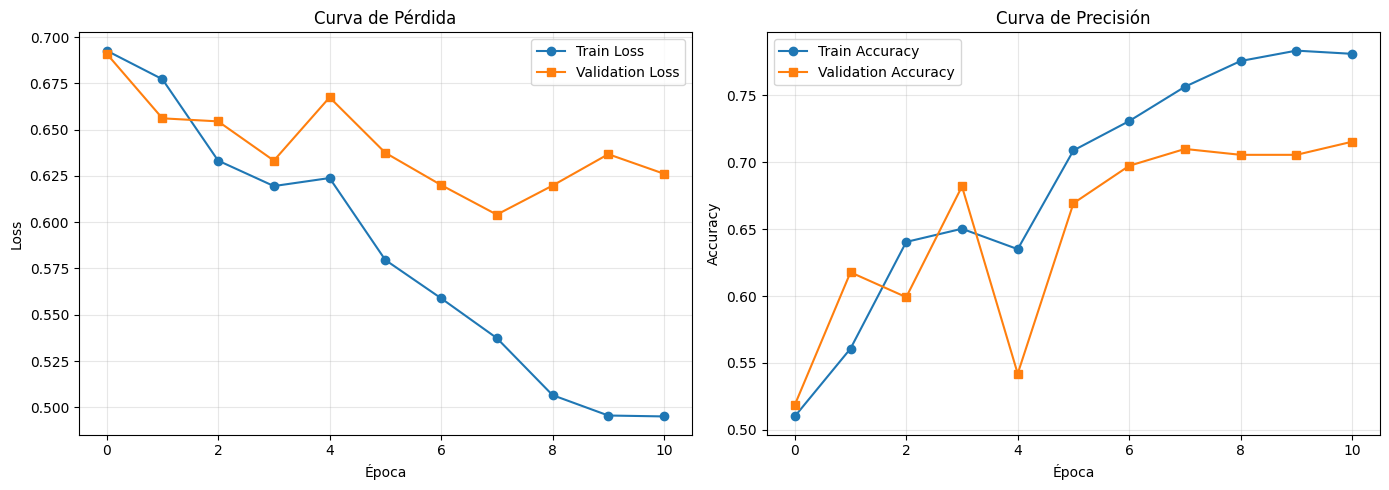


PROYECTO COMPLETADO EXITOSAMENTE

Archivos generados:
  - sentiment_model_weights.pth: Pesos del modelo
  - word_index.pkl: Diccionario de palabras 
  - best_model_checkpoint.pth: Checkpoint completo 
  - training_history.png: Curvas de aprendizaje

El modelo está listo para realizar predicciones

Para realizar inferencia, utiliza el archivo 'inference.py'


In [9]:
if __name__ == "__main__":
    # Entrenar modelo
    model, history, config = main()

    print("\n" + "="*70)
    print("PROYECTO COMPLETADO EXITOSAMENTE")
    print("="*70)
    print("\nArchivos generados:")
    print("  - sentiment_model_weights.pth: Pesos del modelo")
    print("  - word_index.pkl: Diccionario de palabras ")
    print("  - best_model_checkpoint.pth: Checkpoint completo ")
    print("  - training_history.png: Curvas de aprendizaje")
    print("\nEl modelo está listo para realizar predicciones")
    print("\nPara realizar inferencia, utiliza el archivo 'inference.py'")

CUMPLIMIENTO DE REQUISITOS:

---

- Dataset: IMDB (50,000 reseñas) - Datos no estructurados (texto)
- Capa compleja: 2 capas LSTM (recurrentes)
- Regularización: Dropout (50%) en 2 capas
- Hiperparámetros: Ajustados y justificados
- Métricas: Accuracy, Precision, Recall, F1, AUC-ROC (sklearn)
- Framework: PyTorch
- Explicaciones: Documentado completamente
